<a href="https://colab.research.google.com/github/Howl06/practice/blob/main/02face_identification_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# %tensorflow_version 1.x

In [1]:
!pip install mtcnn
# !pip uninstall h5py
!pip install h5py==2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 35.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h5py: filename=h5py-2.10.0-cp310-cp310-linux_x86_64.whl size=5619769 sha256=92d740139c9560adad2c46b39ebeda767e260efd44de79668b95c79cb8cce22f
  Stored in directory: /root/.cache/pip/wheels/21/bc/58/0d0c6056e1339f40188d136cd838c6554d9c17545196dd9110
Successfully built h5py
  Attempting uninstall: h5py
    Found existing installation: h5py 3.8.0
    Uninstalling h5py-3.8.0:
      Successfully uninstalled h5py-3.8.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Download and unzip dataset
!pip install --upgrade gdown
!gdown --fuzzy 1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
!unzip -q "5celeb.zip"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?id=1RJ6MEDV9tYexOTAQDiWZ2bx8fO4HuUAu
To: /content/5celeb.zip
100% 2.73M/2.73M [00:00<00:00, 61.0MB/s]


In [4]:
!pip3 install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import mtcnn
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm.auto import tqdm
from glob import glob

from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K

In [6]:
FOLDER_PATH = '/content/'
IMG_SIZE = 160

In [7]:
detector = MTCNN()
path_train = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/train/*/*.jpg')))
path_val = sorted(glob(os.path.join(FOLDER_PATH, '5celeb/data/val/*/*.jpg')))
len(path_train), len(path_val)

(107, 30)

In [8]:
# extract names
names = []
for path in path_train:
    name = path.split(os.sep)[-2]
    if name not in names:
        names.append(name)
names

['ben_afflek',
 'elton_john',
 'jerry_seinfeld',
 'madonna',
 'mindy_kaling',
 '張鈞甯']

In [9]:
#build class map
cls_map = {}
for i, name in enumerate(names):
    cls_map[name] = int(i)
cls_map

{'ben_afflek': 0,
 'elton_john': 1,
 'jerry_seinfeld': 2,
 'madonna': 3,
 'mindy_kaling': 4,
 '張鈞甯': 5}

In [10]:
# load X(img), y(labels)
def load_data(paths):
    X = np.zeros((len(paths), IMG_SIZE, IMG_SIZE, 3))
    # y = np.zeros((len(paths), 1), dtype=int)
    y = np.zeros((len(paths), 1), dtype=float)
    for i, path in enumerate(tqdm(paths)):
        img = cv2.imread(path)[:, :, ::-1]
        results = detector.detect_faces(img)
        x1, y1, width, height = results[0]['box']
        x2, y2 = x1 + width, y1 + height
        patch = img[max(y1, 0): min(y2, img.shape[0]), max(x1, 0): min(x2, img.shape[1])]
        # resize face
        patch = cv2.resize(patch, (IMG_SIZE, IMG_SIZE))
        name = path.split('/')[-2]
        X[i] = patch
        y[i] = cls_map[name]
    return X, y

In [11]:
X_train, y_train = load_data(path_train)
X_val, y_val = load_data(path_val)

  0%|          | 0/107 [00:00<?, ?it/s]

1/1 [==============================] - 0s 31ms/step


  0%|          | 0/30 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


### Preprocess

In [12]:
X_train = X_train / 255.
X_val = X_val / 255.

[5.] 張鈞甯


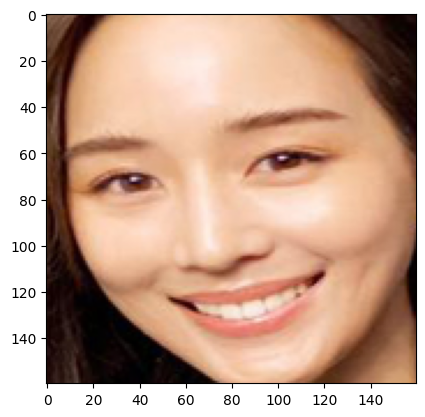

[5.] 張鈞甯


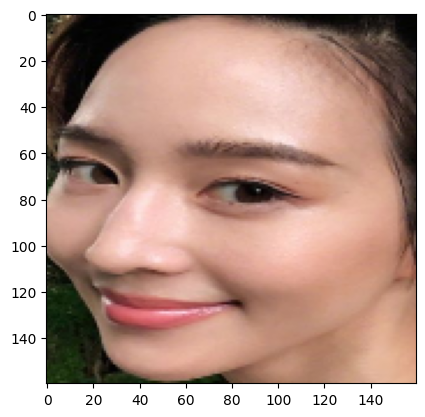

107

In [13]:
for i in range(X_train.shape[0])[105:]:
    print(y_train[i], names[int(y_train[i][0])])
    plt.imshow(X_train[i])
    plt.show()
X_train.shape[0]

In [14]:
def create_pairs(x, face_indices, num_classes):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(face_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            # positive pairs
            z1, z2 = face_indices[d][i], face_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            # negative pairs
            inc = np.random.randint(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = face_indices[d][i], face_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

# create training+test positive and negative pairs
face_indices = [np.where(y_train == i)[0] for i in range(len(names))]
train_pairs, train_y = create_pairs(X_train, face_indices, num_classes=len(names))

face_indices = [np.where(y_val == i)[0] for i in range(len(names))]
val_pairs, val_y = create_pairs(X_val, face_indices, num_classes=len(names))

In [15]:
train_pairs.shape, train_y.shape, val_pairs.shape, val_y.shape

((156, 2, 160, 160, 3), (156,), (48, 2, 160, 160, 3), (48,))

In [16]:
train_y = train_y.astype(np.float64)
val_y = val_y.astype(np.float64)

In [18]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 6 # 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [19]:
# build model
# network definition
base_network = keras.applications.resnet50.ResNet50(include_top=False, 
                                                    weights=None, 
                                                    input_shape=(IMG_SIZE, IMG_SIZE, 3))

input_a = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
input_b = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
global_avg = GlobalAveragePooling2D() # Flatten
processed_a = base_network(input_a)
processed_a = global_avg(processed_a)

processed_b = base_network(input_b)
processed_b = global_avg(processed_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

In [20]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 5, 5, 2048)   23587712    ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

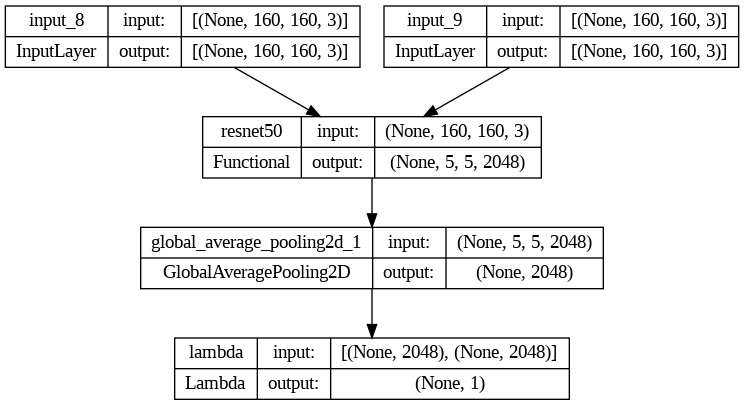

In [21]:
plot_model(model, show_shapes=True)

In [22]:
earlystop = EarlyStopping(patience=10)
model_ckp = ModelCheckpoint(os.path.join('model_siamese.h5'), 
                            save_best_only=True, 
                            save_weights_only=False)

# train
model.compile(loss=contrastive_loss, 
              optimizer='adam', 
              metrics=[])

model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_y,
          batch_size=32,
          epochs=1000,
          callbacks=[earlystop, model_ckp],
          validation_data=([val_pairs[:, 0], val_pairs[:, 1]], val_y))

Epoch 1/1000
5/5 [==============================] - 154s 26s/step - loss: 207.8944 - val_loss: 16.7678
Epoch 2/1000
5/5 [==============================] - 125s 26s/step - loss: 43.0136 - val_loss: 16.7032
Epoch 3/1000
5/5 [==============================] - 124s 25s/step - loss: 22.5477 - val_loss: 16.6675
Epoch 4/1000
5/5 [==============================] - 121s 24s/step - loss: 13.0594 - val_loss: 16.4583
Epoch 5/1000
5/5 [==============================] - 124s 25s/step - loss: 9.4597 - val_loss: 16.2934
Epoch 6/1000
5/5 [==============================] - 121s 25s/step - loss: 8.7181 - val_loss: 16.2098
Epoch 7/1000
5/5 [==============================] - 124s 25s/step - loss: 8.6089 - val_loss: 16.0410
Epoch 8/1000
5/5 [==============================] - 123s 25s/step - loss: 8.3128 - val_loss: 15.6405
Epoch 9/1000
5/5 [==============================] - 124s 25s/step - loss: 7.5181 - val_loss: 15.2198
Epoch 10/1000
5/5 [==============================] - 121s 25s/step - loss: 6.9850 - va

In [23]:
#Download pretrained model
!gdown --id 1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV -O model.h5

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (uriginal): https://drive.google.com/uc?id=1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV
From (redirected): https://drive.google.com/uc?id=1JCo1g2sBkG-CwBbqOYlZ1KdGvRcjKTYV&confirm=t&uuid=6a4fcbb8-214f-43da-944c-45540db5df18
To: /content/model.h5
100% 283M/283M [00:05<00:00, 53.8MB/s]


In [24]:
model.load_weights('/content/drive/MyDrive/model_siamese.h5')

In [ ]:
# load model
# method1: compile=False
# model = load_model('model.h5', compile=False)
# method 2
model = load_model('model.h5', 
                   custom_objects={'contrastive_loss': contrastive_loss})

ValueError: ignored

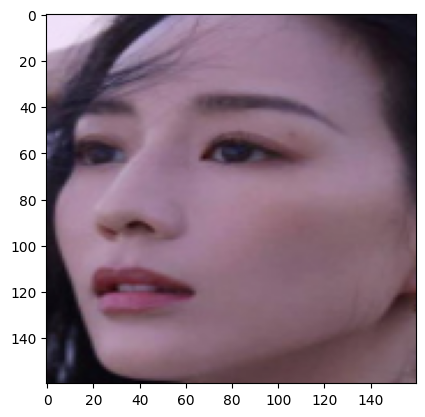

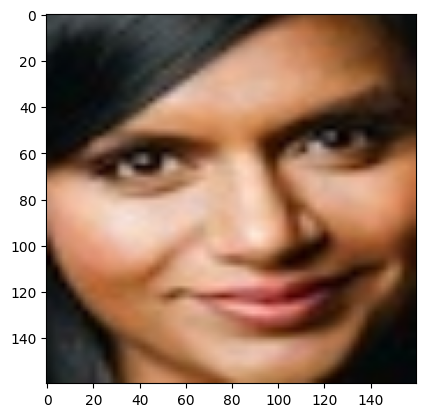

label:  0.0  val data shape:  (1, 2, 160, 160, 3)
1/1 [==============================] - 0s 250ms/step
Distance:  [[3.5546105]]


In [42]:
# Evaluation
idx = np.random.randint(0, val_pairs.shape[0])
pair = val_pairs[idx]
label = val_y[idx]
imgA, imgB = pair[0], pair[1]
plt.imshow(imgA)
plt.show()
plt.imshow(imgB)
plt.show()
print('label: ', label, ' val data shape: ',val_pairs[idx:idx+1].shape)
print('Distance: ', model.predict([np.expand_dims(imgA, axis=0), np.expand_dims(imgB, axis=0)]))

In [28]:
all_pairs = np.concatenate((train_pairs, val_pairs))
all_labels = np.concatenate((train_y, val_y))

In [29]:
positive_pairs = all_pairs[all_labels == 1] 
negative_pairs = all_pairs[all_labels == 0]

In [30]:
positive_distances = model.predict([positive_pairs[:, 0], positive_pairs[:, 1]])
negative_distances = model.predict([negative_pairs[:, 0], negative_pairs[:, 1]])

4/4 [==============================] - 16s 4s/step


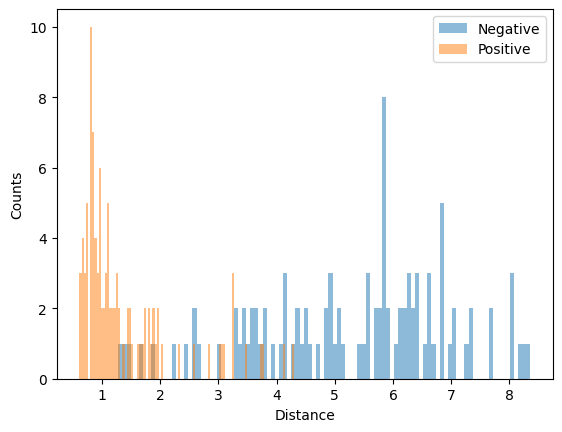

In [43]:
plt.hist(negative_distances[:,0], bins=100, alpha=0.5)
plt.hist(positive_distances[:,0], bins=100, alpha=0.5)
plt.legend(['Negative', 'Positive'])
plt.xlabel('Distance')
plt.ylabel('Counts')
plt.show()
# 用Distance 來區分